# Class activation mapping:
Visualizing image regions resposible for predictions

Here is the paper that introduced this technique [paper](https://arxiv.org/abs/1512.04150)

In [1]:
import torch

In [2]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import random
from scipy.io import loadmat
from os import listdir
import torch.optim as optim

import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import math

from torchvision import models

In [3]:
DATA = Path("/data1/datasets/320")

## Data

In [6]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, rand_r, start_c, nr=300, nc=300):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    r_pix = (r - nr)//2
    c_pix = (c - nc)//2
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, nr, nc)

def center_crop(x, nr=300, nc=300):
    r, c,*_ = x.shape
    r_pix = (r - nr)//2
    c_pix = (c - nc)//2
    return crop(x, r_pix, c_pix, nr, nc)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [7]:
train_df = pd.read_csv(DATA/"train.csv")
valid_df = pd.read_csv(DATA/"valid.csv")

## Dataset

In [8]:
classes = np.sort(train_df["y"].unique())
class2id ={v:k for k,v in enumerate(classes)}

In [9]:
def apply_transforms(x, rand_arr, nr, nc):
    """ Applies a random crop, rotation"""
    rdeg = (rand_arr[0] -.50)*10
    x = rotate_cv(x, rdeg)
    if rand_arr[1] > 0.5: x = np.fliplr(x).copy() 
    x = random_crop(x, rand_arr[2], rand_arr[3], nr, nc)
    return x

In [10]:
class ImageNetDataSet(Dataset):
    def __init__(self, df, nr=300, transform=None):
        """
        Args:
            dataframe with data: image_file, label
            transform: if True apply transforms to images
        """
        self.image_files = df["x"].values
        self.labels = [class2id[y] for y in df["y"].values]
        self.transform = transform
        self.len = len(self.image_files)
        self.random_init()
        self.nr=nr
        
    def random_init(self):
        self.random = np.random.rand(self.len, 4)

    def __getitem__(self, index):
        path = DATA/self.image_files[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            x = apply_transforms(x, self.random[index], nr=self.nr, nc=self.nr)
        else:
            x = center_crop(x, nr=self.nr, nc=self.nr)
            
        y = self.labels[index]
        return np.rollaxis(x, 2), y

    def __len__(self):
        return self.len

In [11]:
def normalize_tensors_float(x, y):
    # normalized 
    mean = torch.tensor([0.485 * 255, 0.456 * 255, 0.406 * 255]).cuda().view(1,3,1,1)
    std = torch.tensor([0.229 * 255, 0.224 * 255, 0.225 * 255]).cuda().view(1,3,1,1)
    x = x.cuda(non_blocking=True) 
    return x.sub_(mean).div_(std), y.cuda(non_blocking=True)

In [12]:
train_df = pd.read_csv(DATA/"train.csv")
valid_df = pd.read_csv(DATA/"valid.csv")

In [13]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

## Load a pre-trained model

In [18]:
# OR 
model = models.resnet18(pretrained=True).cuda()

## Compute CAM

In [17]:
def get_cnn_volume_from_resnet(model, x):
    x_norm, y_norm = normalize_tensors_float(x, y)
    x = model.conv1(x_norm)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)
    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    return x.detach().cpu().numpy()

In [25]:
def get_last_linear_layer(model):
    return model.fc.weight.data.cpu().numpy()

In [26]:
def get_cam(x_vol, last_weight_layer):
    """Compute CAM
    """
    N, K, H, W = x_vol.shape
    C, K = last_weight_layer.shape
    class_act_map = np.zeros((N, C, H, W))
    for i in range(N):
        tmp = last_weight_layer.dot(x_vol[i].reshape(K, H*W))
        class_act_map[i, :, :, :] = tmp.reshape(-1, H, W)
    return class_act_map

In [41]:
def plot_figures(x_vol, x, class_act_map):
    N = x_vol.shape[0]
    _, _, width, height = x.shape
    X = np.rollaxis(x.numpy(), 1, 4)
    fig, axs = plt.subplots(2, N)
    fig.set_size_inches(14, 5)
    for i in range(N):
        cam = class_act_map[i, y[i], :, :]
        heat_map = cv2.resize(cam, (width, height))
        heat_map /= heat_map.max()
        im = X[i].astype(np.float32)/255
        im_show = im*0.5 + plt.cm.jet(heat_map)[:, :, :3]*0.5
        axs[0, i].imshow(im)
        axs[1, i].imshow(im_show)

## Apply cam to some data

In [27]:
train_df = pd.read_csv(DATA/"train.csv")
valid_ds = ImageNetDataSet(valid_df[:5])

In [28]:
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), num_workers=1)

In [29]:
x, y = next(iter(valid_dl))
x.shape, y

(torch.Size([5, 3, 300, 300]), tensor([955, 955, 955, 955, 955]))

In [30]:
x_vol = get_cnn_volume_from_resnet(model, x)
x_vol.shape

(5, 512, 10, 10)

In [31]:
last_weight_layer = get_last_linear_layer(model)
last_weight_layer.shape

(1000, 512)

In [32]:
class_act_map = get_cam(x_vol, last_weight_layer)
class_act_map.shape

(5, 1000, 10, 10)

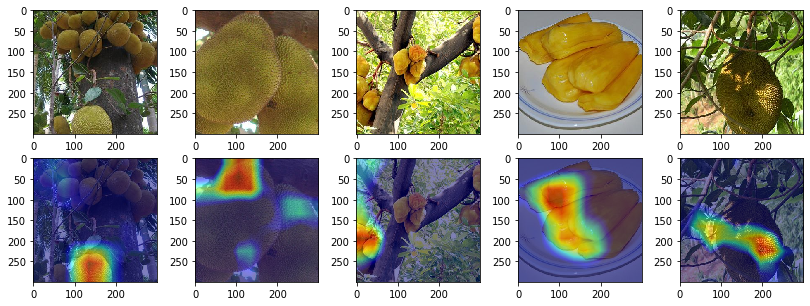

In [40]:
plot_figures(x_vol, x, class_act_map)

## More data

In [44]:
train_df = pd.read_csv(DATA/"train.csv")
valid_ds = ImageNetDataSet(valid_df[5000:5005])
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), num_workers=1)
x, y = next(iter(valid_dl))
x.shape, y

(torch.Size([5, 3, 300, 300]), tensor([895, 895, 895, 895, 895]))

In [45]:
x_vol = get_cnn_volume_from_resnet(model, x)
last_weight_layer = get_last_linear_layer(model)
class_act_map = get_cam(x_vol, last_weight_layer)

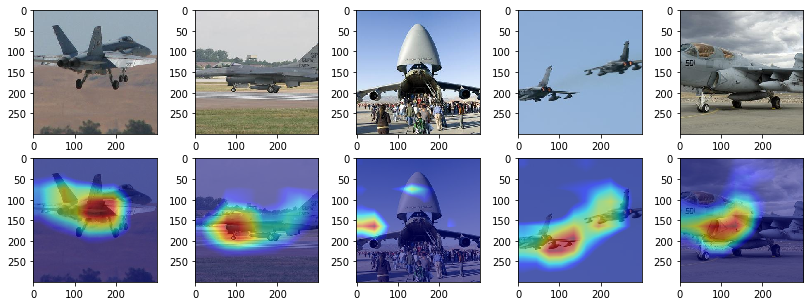

In [46]:
plot_figures(x_vol, x, class_act_map)

In [49]:
train_df = pd.read_csv(DATA/"train.csv")
valid_ds = ImageNetDataSet(valid_df[10003:10008])
valid_dl = DataLoader(valid_ds, batch_size=len(valid_ds), num_workers=1)
x, y = next(iter(valid_dl))
x.shape, y

(torch.Size([5, 3, 300, 300]), tensor([699, 699, 699, 699, 699]))

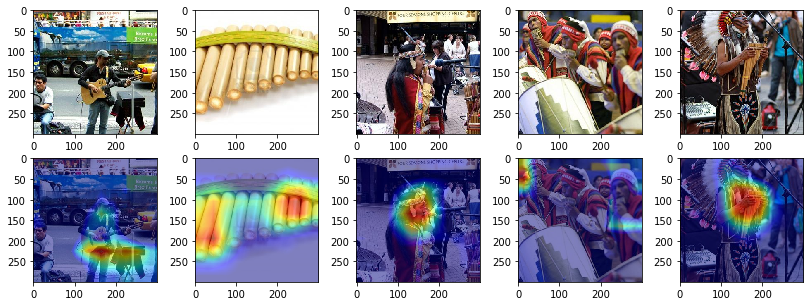

In [50]:
x_vol = get_cnn_volume_from_resnet(model, x)
last_weight_layer = get_last_linear_layer(model)
class_act_map = get_cam(x_vol, last_weight_layer)
plot_figures(x_vol, x, class_act_map)

## References
* https://github.com/SafwanMahmood/Learning-Deep-Features-for-Discriminative-Localization/blob/master/mxnetimplementation/CAM.ipynb